In [1]:
import os, numpy as np, torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
import time, copy, math
from collections import Counter

In [19]:
# STEP1: Set up directories
training_dir = Path("C:/Users/tomla/Documents/Projects/brain_tumor_classifier/data/combined_split_simple/training/")
testing_dir = Path("C:/Users/tomla/Documents/Projects/brain_tumor_classifier/data/combined_split_simple/testing/")
original_test_dir = Path("C:/Users/tomla/Documents/Projects/brain_tumor_classifier/data/testing/")
OUTPUT_MODELS = Path("C:/Users/tomla/Documents/Projects/brain_tumor_classifier/models/")
OUTPUT_EDA = Path("C:/Users/tomla/Documents/Projects/brain_tumor_classifier/outputs/misclassification/")
OUTPUT_EDA.mkdir(parents=True, exist_ok=True)
OUTPUT_MODELS.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

In [3]:
# STEP 2: Set up transforms for image Normalization and Augmentation

# Image Normalization paramters for ResNet18
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(15), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}

In [4]:
# STEP 3: Create Dataloaders

# Load full training set
full_train = ImageFolder(training_dir, transform=data_transforms["train"]) # load full training dataset and assigns label to each image based on folder class
y = np.array([label for _, label in full_train.samples]) # extract labels

# Create stratified split (80% train / 20% val)
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(ss.split(np.zeros(len(y)), y)) # create indices for train/val split (requires X, y so zero array is used as X)

# training set
train_data = Subset(full_train, train_idx)

# validation set
val_train = ImageFolder(training_dir, transform=data_transforms["val"]) # load full training dataset without agumentations
val_data = Subset(val_train, val_idx)

# final test set
test_data = ImageFolder(testing_dir, transform=data_transforms["test"])

# original test set
original_test_data = ImageFolder(original_test_dir, transform=data_transforms["test"])

# Loaders
BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
original_test_loader = DataLoader(original_test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names = full_train.classes  # ordered by subfolder name
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [5]:
# STEP 4: Load pretrained Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# replace final layer for 4 classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)


In [ ]:
# STEP 5: Run Train/validate loop with metrics

criterion = nn.CrossEntropyLoss()

# Optimizer / scheduler
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # gentle decay

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return acc, prec, rec, f1, y_true, y_pred

EPOCHS = 15
best_wts = copy.deepcopy(model.state_dict())
best_f1 = -math.inf

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # ---- train ----
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * xb.size(0)

    scheduler.step()
    train_loss = running_loss / len(train_loader.dataset)

    # ---- validate ----
    val_acc, val_prec, val_rec, val_f1, y_true, y_pred = evaluate(model, val_loader, device)

    # track best
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        best_wts = copy.deepcopy(model.state_dict())
        

    dt = time.time() - t0
    print(f"[{epoch:02d}/{EPOCHS}] {dt:.1f}s  TrainLoss={train_loss:.4f}  "
          f"Val: Acc={val_acc:.3f}  P={val_prec:.3f}  R={val_rec:.3f}  F1={val_f1:.3f}")

# load best weights
model.load_state_dict(best_wts)
torch.save(model.state_dict(), OUTPUT_MODELS / f"resnet18_best_valF1_{best_f1:.4f}_epoch{best_epoch}.pth")

print(f"Saved best model from epoch {best_epoch} (F1={best_f1:.4f})")


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[01/15] 18.5s  TrainLoss=0.5750  Val: Acc=0.895  P=0.905  R=0.890  F1=0.896


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[02/15] 17.3s  TrainLoss=0.2224  Val: Acc=0.933  P=0.941  R=0.929  F1=0.935


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[03/15] 17.0s  TrainLoss=0.1249  Val: Acc=0.939  P=0.943  R=0.942  F1=0.941


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[04/15] 17.0s  TrainLoss=0.1076  Val: Acc=0.950  P=0.952  R=0.953  F1=0.953


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[05/15] 17.4s  TrainLoss=0.0858  Val: Acc=0.962  P=0.960  R=0.962  F1=0.961


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[06/15] 17.2s  TrainLoss=0.0413  Val: Acc=0.966  P=0.967  R=0.964  F1=0.965


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[07/15] 16.5s  TrainLoss=0.0340  Val: Acc=0.966  P=0.969  R=0.961  F1=0.965


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[08/15] 16.8s  TrainLoss=0.0250  Val: Acc=0.967  P=0.967  R=0.968  F1=0.968


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[09/15] 17.0s  TrainLoss=0.0283  Val: Acc=0.969  P=0.971  R=0.969  F1=0.970


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[10/15] 16.6s  TrainLoss=0.0246  Val: Acc=0.973  P=0.974  R=0.974  F1=0.974


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[11/15] 16.8s  TrainLoss=0.0234  Val: Acc=0.977  P=0.977  R=0.977  F1=0.977


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[12/15] 16.8s  TrainLoss=0.0141  Val: Acc=0.973  P=0.974  R=0.974  F1=0.974


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[13/15] 16.6s  TrainLoss=0.0095  Val: Acc=0.967  P=0.971  R=0.964  F1=0.967


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[14/15] 16.6s  TrainLoss=0.0108  Val: Acc=0.975  P=0.975  R=0.974  F1=0.974


C:\Users\tomla\AppData\Local\Temp\ipykernel_10968\852800106.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[15/15] 16.8s  TrainLoss=0.0124  Val: Acc=0.975  P=0.975  R=0.972  F1=0.974


<All keys matched successfully>

In [7]:
# STEP 6: Model evaluation on test set
test_acc, test_prec, test_rec, test_f1, y_true, y_pred = evaluate(model, test_loader, device)
print(f"TEST — Acc={test_acc:.3f}  P={test_prec:.3f}  R={test_rec:.3f}  F1={test_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

TEST — Acc=0.959  P=0.960  R=0.960  F1=0.960
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.93      0.94       185
meningioma_tumor       0.93      0.96      0.95       187
        no_tumor       0.96      0.97      0.97       100
 pituitary_tumor       1.00      0.98      0.99       180

        accuracy                           0.96       652
       macro avg       0.96      0.96      0.96       652
    weighted avg       0.96      0.96      0.96       652



In [8]:
# STEP 7: Final model evaluation on the original test set
test_acc, test_prec, test_rec, test_f1, y_true, y_pred = evaluate(model, original_test_loader, device)
print(f"ORIGINAL TEST — Acc={test_acc:.3f}  P={test_prec:.3f}  R={test_rec:.3f}  F1={test_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

ORIGINAL TEST — Acc=0.959  P=0.964  R=0.960  F1=0.960
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.87      0.93       100
meningioma_tumor       0.93      0.99      0.96       115
        no_tumor       0.95      0.99      0.97       105
 pituitary_tumor       0.99      0.99      0.99        74

        accuracy                           0.96       394
       macro avg       0.96      0.96      0.96       394
    weighted avg       0.96      0.96      0.96       394



## Error Analysis

In [9]:
def report_on_loader(model, loader, class_names, device, title=""):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    # Per-class metrics
    print(f"\n=== {title} — classification report ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

    # Confusion matrices (counts + row-normalized)
    for normalize, name in [(None, "Counts"), ("true", "Row-normalized (Recall)")]:
        cm = confusion_matrix(y_true, y_pred, normalize=normalize)
        plt.figure(figsize=(6,5))
        im = plt.imshow(cm, interpolation="nearest")
        plt.title(f"{title} — Confusion Matrix ({name})")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha="right")
        plt.yticks(ticks, class_names)
        # annotate cells
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                txt = f"{cm[i,j]:.2f}" if normalize else str(int(cm[i,j]))
                plt.text(j, i, txt, ha="center", va="center")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    return y_true, y_pred


=== NEW TEST — classification report ===
                  precision    recall  f1-score   support

    glioma_tumor      0.945     0.930     0.937       185
meningioma_tumor      0.933     0.963     0.947       187
        no_tumor      0.960     0.970     0.965       100
 pituitary_tumor      1.000     0.978     0.989       180

        accuracy                          0.959       652
       macro avg      0.960     0.960     0.960       652
    weighted avg      0.959     0.959     0.959       652



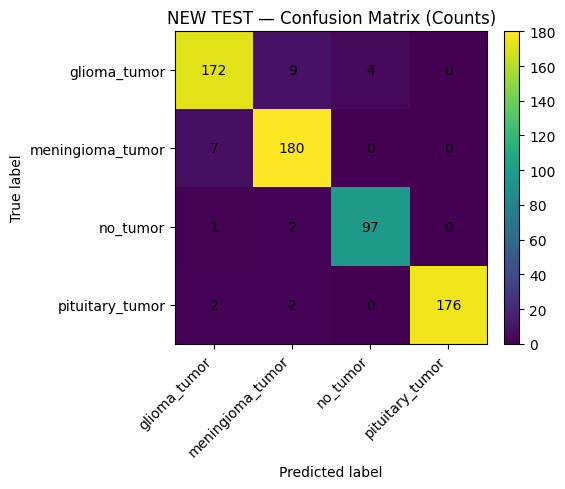

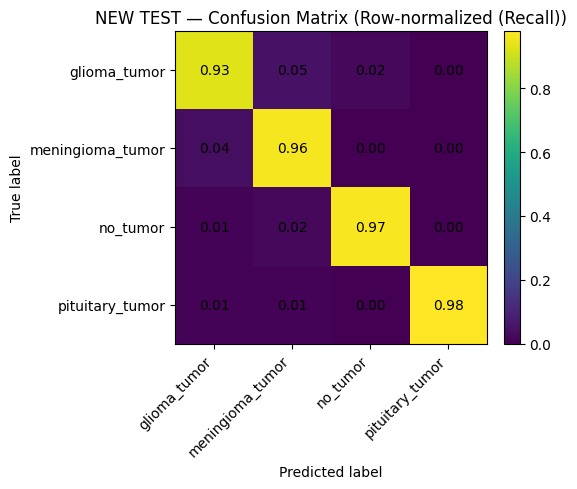


=== ORIGINAL TEST — classification report ===
                  precision    recall  f1-score   support

    glioma_tumor      0.989     0.870     0.926       100
meningioma_tumor      0.927     0.991     0.958       115
        no_tumor      0.954     0.990     0.972       105
 pituitary_tumor      0.986     0.986     0.986        74

        accuracy                          0.959       394
       macro avg      0.964     0.960     0.960       394
    weighted avg      0.961     0.959     0.959       394



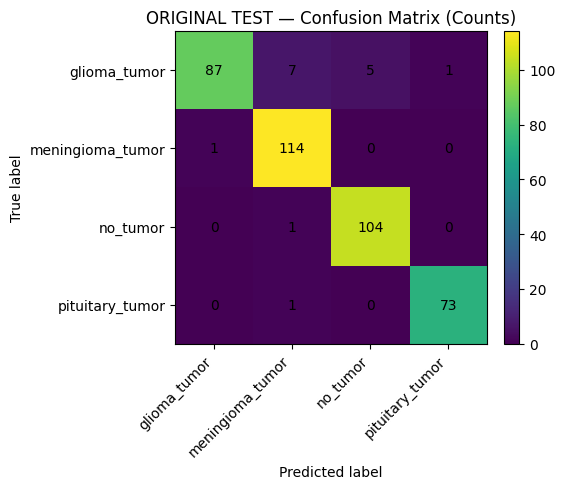

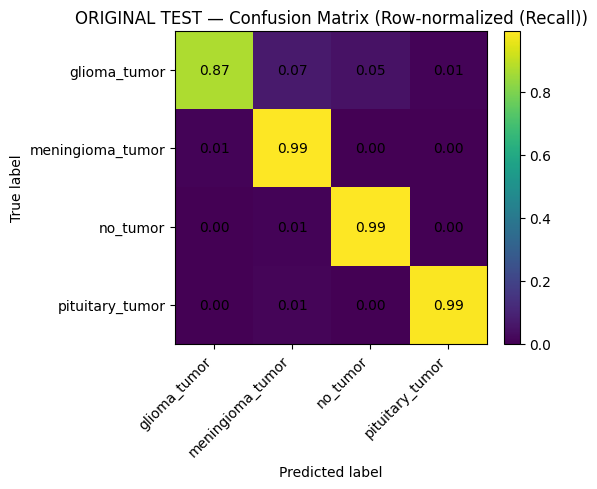

In [10]:
y_true_new, y_pred_new = report_on_loader(model, test_loader, class_names, device, title="NEW TEST")
y_true_ext, y_pred_ext = report_on_loader(model, original_test_loader, class_names, device, title="ORIGINAL TEST")

In [16]:
def get_paths_for_dataset(ds):
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        return [base.samples[i][0] for i in idxs]
    else:
        return [s[0] for s in ds.samples]

@torch.inference_mode()
def infer_collect(model, loader, device):
    model.eval()
    all_y, all_pred, all_prob = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        all_y.append(yb.cpu().numpy())
        all_pred.append(probs.argmax(1).cpu().numpy())
        all_prob.append(probs.cpu().numpy())
    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_pred)
    probs  = np.concatenate(all_prob, axis=0)
    return y_true, y_pred, probs

def top_mistakes_per_true_class(y_true, y_pred, probs, paths, max_per_class, n_classes):
    mistakes = []
    idxs = np.where(y_pred != y_true)[0]
    for i in idxs:
        mistakes.append({
            "path": paths[i],
            "true": int(y_true[i]),
            "pred": int(y_pred[i]),
            "conf": float(probs[i, y_pred[i]])
        })
    mistakes.sort(key=lambda d: d["conf"], reverse=True)
    picked, counts = [], [0]*n_classes
    for m in mistakes:
        t = m["true"]
        if counts[t] < max_per_class:
            picked.append(m); counts[t] += 1
    return picked

def show_misclassification_gallery(mistakes, class_names, cols=6, title=""):
    if not mistakes:
        print("No misclassifications 🎉"); return
    rows = int(np.ceil(len(mistakes) / cols))
    plt.figure(figsize=(3*cols, 3.3*rows))
    for i, m in enumerate(mistakes, 1):
        ax = plt.subplot(rows, cols, i)
        img = ImageOps.exif_transpose(Image.open(m["path"])).convert("L")
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"{class_names[m['true']]} → {class_names[m['pred']]}\nconf={m['conf']:.2f}", fontsize=9)
        ax.axis("off")
    
    if title != "":
        plt.savefig(os.path.join(OUTPUT_EDA, f"misclass_{title}.png"))
    plt.tight_layout(); plt.show()



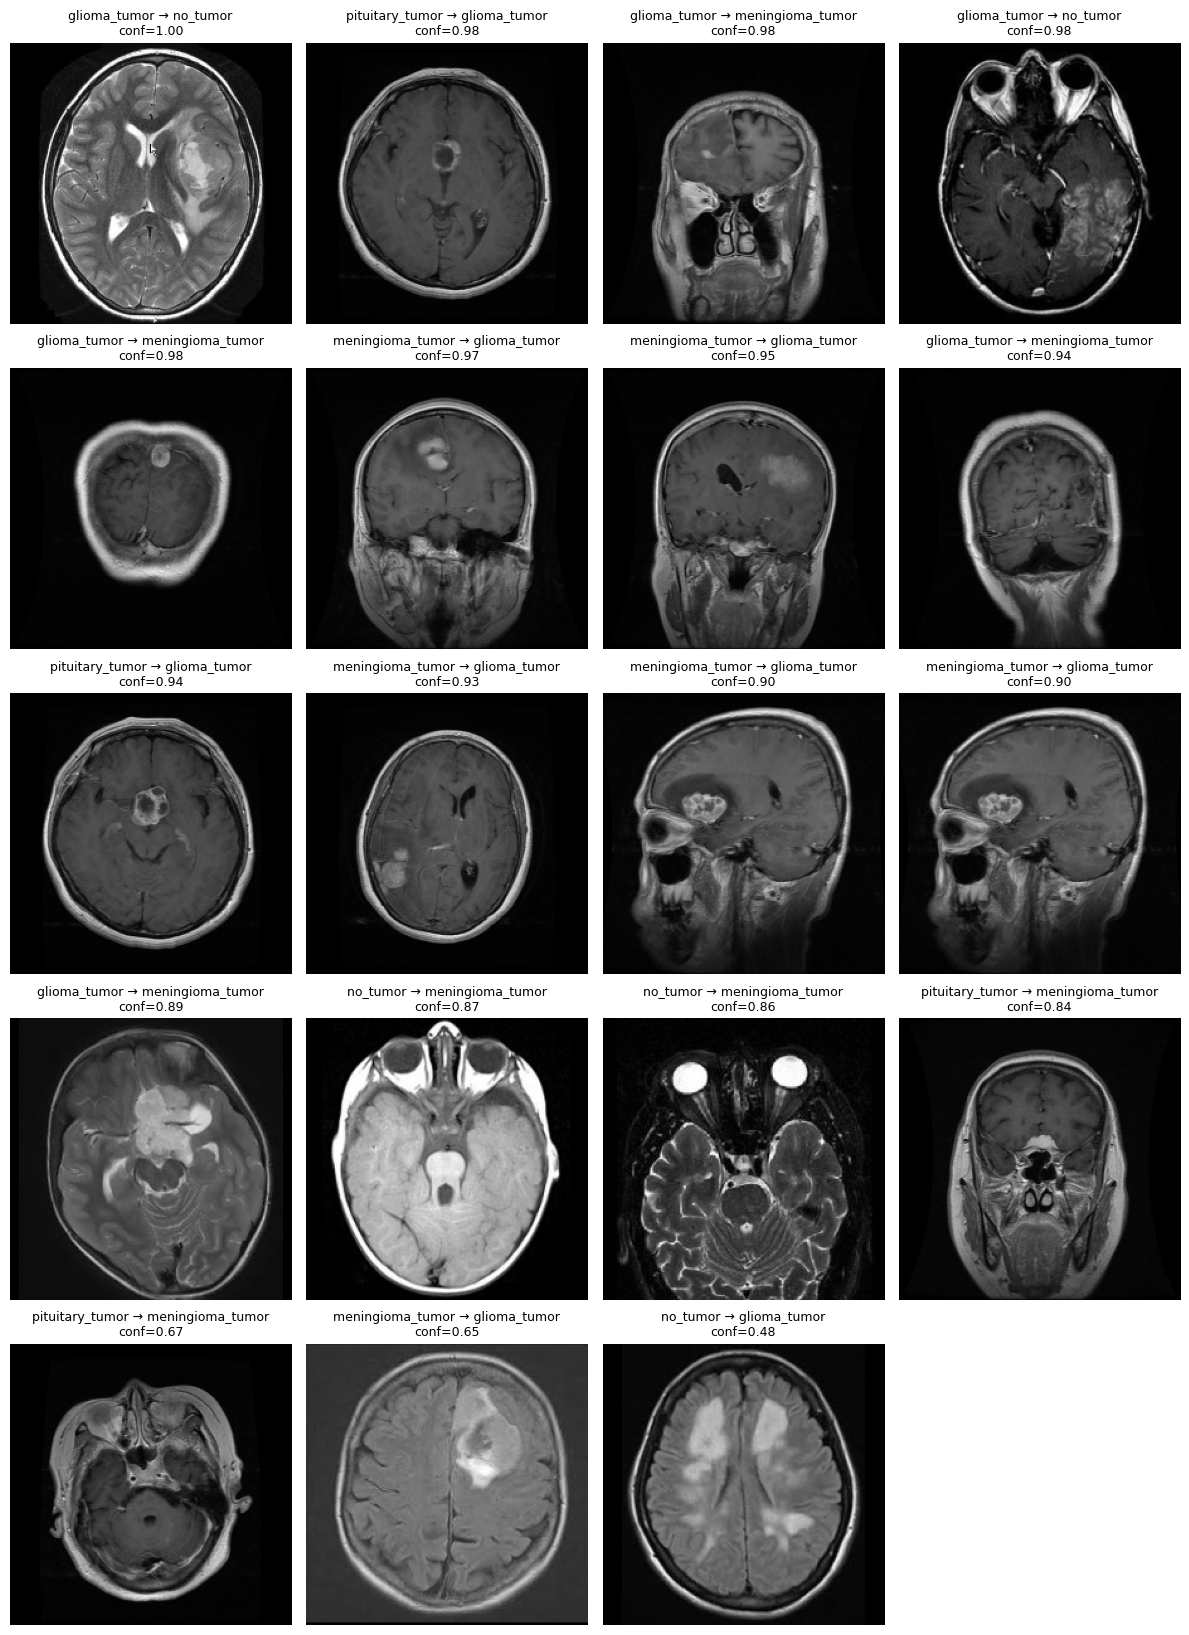

In [20]:
paths = get_paths_for_dataset(test_loader.dataset)
y_true, y_pred, probs = infer_collect(model, test_loader, device)
mistakes = top_mistakes_per_true_class(y_true, y_pred, probs, paths, max_per_class=6, n_classes=len(class_names))
show_misclassification_gallery(mistakes, class_names, cols=4, title="new_testset")

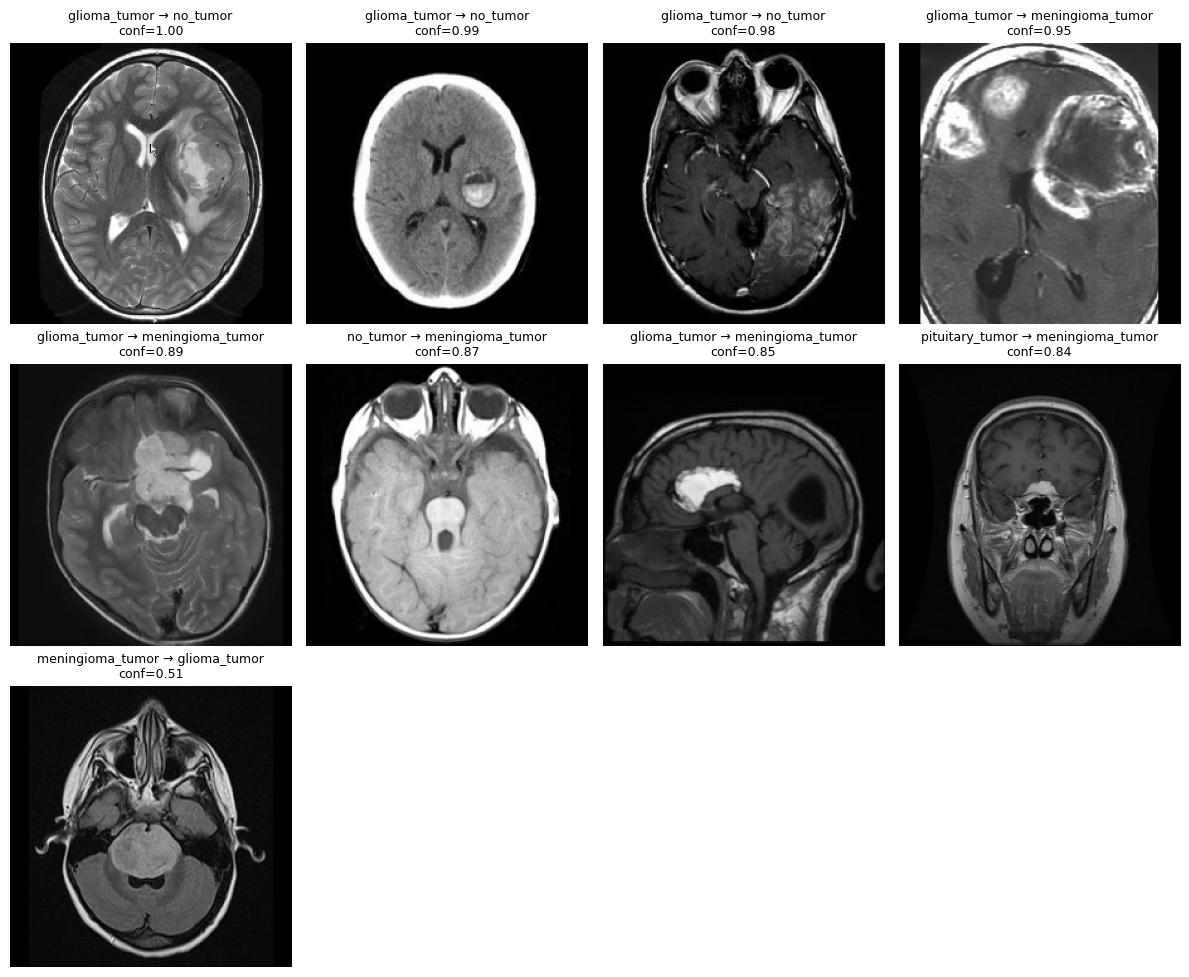

In [21]:
paths = get_paths_for_dataset(original_test_loader.dataset)
y_true, y_pred, probs = infer_collect(model, original_test_loader, device)
mistakes = top_mistakes_per_true_class(y_true, y_pred, probs, paths, max_per_class=6, n_classes=len(class_names))
show_misclassification_gallery(mistakes, class_names, cols=4, title="original_testset")